In [1]:
import pandas as pd
import numpy as np
import warnings
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline
plt.style.use('dark_background')

## About:
This notebook explores the methods used in the paper by Omari et al. to fit a statistical distribution to car insurance severity from a dataset available online.

It was my intention to replicate the study using python, but unfortunately the datasets used in the paper are not available outside of R. Instead I used a dataset posted on a public forum as a basis for this study.

Link to Paper: https://www.researchgate.net/publication/323379447_Modeling_the_Frequency_and_Severity_of_Auto_Insurance_Claims_Using_Statistical_Distributions

Link to post containing dataset (used Emcien data): https://opendata.stackexchange.com/questions/7807/where-can-i-find-automobile-insurance-claims-data-set

### Initial Data Analysis

In [2]:
auto_claims = pd.read_csv('Auto_Insurance_Claims_Sample.csv')

In [3]:
auto_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 26 columns):
Customer                         9134 non-null object
Country                          9134 non-null object
State Code                       9134 non-null object
State                            9134 non-null object
Claim Amount                     9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception  

No null entries in the data

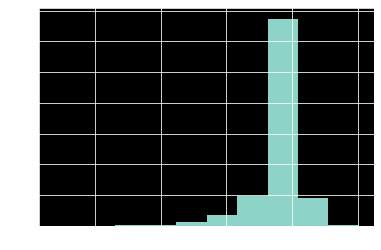

In [4]:
auto_claims['claim_amount_diff'] = auto_claims['Total Claim Amount'] - auto_claims['Claim Amount']
auto_claims['claim_amount_diff'].hist()

Curiously the Total Claim amount differs from the Claim amount in various cases. Why does this happen? I'll put this aside for now and perhaps come back to it later

Without someone who knows about the data is hard to know why it happens. I'll work using Claim Amount for this study

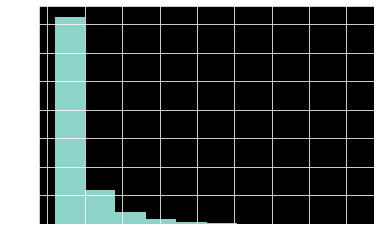

In [5]:
auto_claims['Claim Amount'].hist()

Claim amount distribution is right-skewed as expected

In [6]:
severity = auto_claims['Claim Amount'].to_numpy()

In [7]:
severity_stats = {
    'count' :  len(severity),
    'min' : severity.min(),
    'max' : severity.max(),
    'mean' : severity.mean(),
    'median' : np.median(severity),
    'std' : np.std(severity),
    'skewness' : stats.skew(severity),
    'kurtosis' : stats.kurtosis(severity),
}

In [8]:
for stat, val in severity_stats.items():
    print(stat.ljust(10), str(val).rjust(3))

count      9134
min        189.8007675
max        8332.538118999999
mean       800.4940474987081
median     578.0182197
std        687.0591477654132
skewness   3.031782271327885
kurtosis   13.815310695287437


As the original data is heavily skewed, let's take the log of the severity values

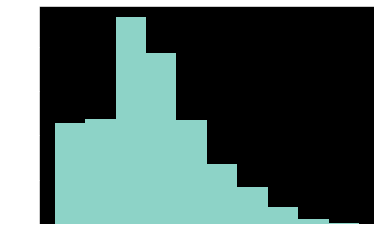

In [9]:
log_severity = np.log(severity)

plt.hist(log_severity)
plt.show()

It looks like we the log of the data is more likely to be fit to a distribution than the original values.

For an experiment, let's also take the log of log_severity

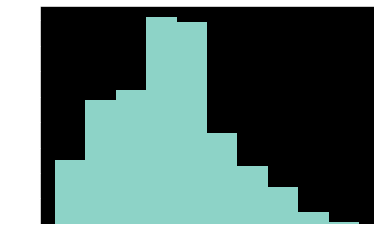

In [10]:
log_log_severity = np.log(log_severity)

plt.hist(log_log_severity)
plt.show()

### Fit Distributions
Distributions to test:
* Exponential
* Gamma
* lognormal
* Weibull
* Pareto

In [11]:
distributions = ['expon', 'gamma', 'lognorm', 'pareto', 'weibull_min']

*Note:* The fit method of the distributions uses MLE to estimate the parameter

In [12]:
def fit_plot_distributions(dataset, title, distributions=distributions):
    fig, (cdf_ax, pdf_ax) = plt.subplots(figsize=(14,6), nrows=1, ncols=2)
    x_min, x_max = dataset.min(), dataset.max()
    x = np.linspace(x_min, x_max, 100)
    cm = cmap.get_cmap('Dark2' ,len(distributions))
    colors = cm(range(len(distributions)))
    
    pdf_ax.hist(dataset, color='r', density=True, alpha=0.3)
    
    ecdf = ECDF(dataset)
    cdf_ax.plot(ecdf.x, ecdf.y, c='r', label=title)
    
    fitted = {}
    for name,color in zip(distributions, colors):
        dist = getattr(stats, name)
        params = dist.fit(dataset)
        frozen_dist = dist(*params)
        fitted[name] = frozen_dist
        cdf_ax.plot(x, frozen_dist.cdf(x), c=color, label=name)
        pdf_ax.plot(x, frozen_dist.pdf(x), c=color ,label=name)
    
    pdf_ax.set_ylabel('pdf')
    pdf_ax.set_title(f'Distribution fits for {title}')
    pdf_ax.legend(loc='best', frameon=False)    
    
    cdf_ax.set_ylabel('cdf')
    cdf_ax.set_title(f'Empirical CDF for {title}')
    cdf_ax.legend(loc='best', frameon=False)
    
    plt.show()
    return fitted

/home/carlos/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


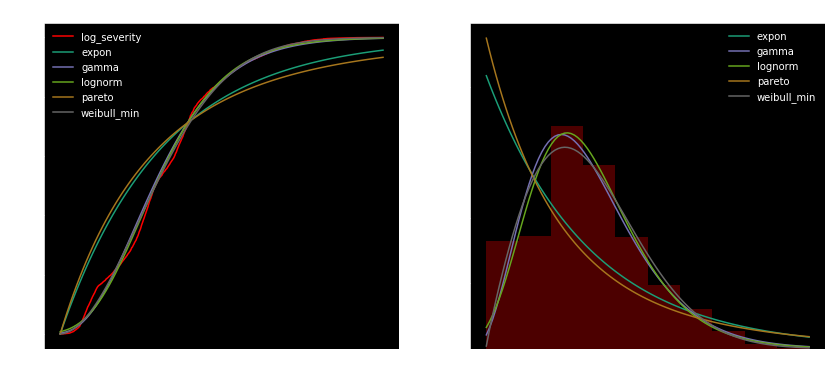

In [13]:
log_sev_dists = fit_plot_distributions(log_severity, 'log_severity')

For log_severity, gamma, lognorm and weibull_min are good fits.

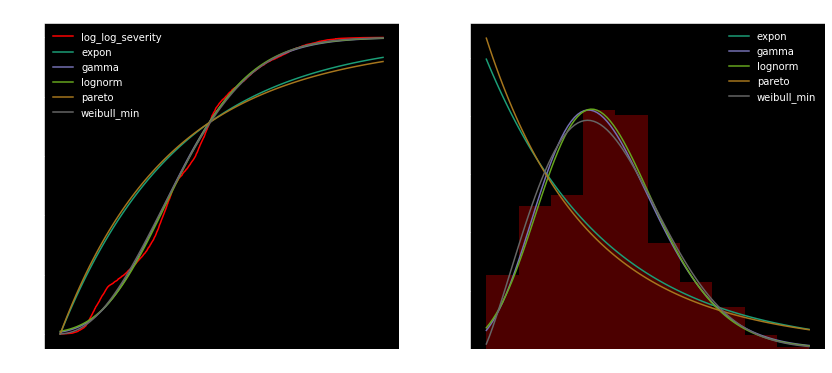

In [14]:
log_log_sev_dists = fit_plot_distributions(log_log_severity, 'log_log_severity')

for log_log_severity, gamma and lognorm are better fits

### Information Criteria

Interesting article on AIC: www.r-bloggers.com/how-do-i-interpret-the-aic

Recall that the log likelihood function for a parameter $\theta$ is 
$$ l(\theta) = \sum_{i=1}^{n}\ln{f(x_i|\theta)} $$
Hence we can use *stats.logpdf* to calculate the loglikelihood of each point in our dataset and use this value to calculate the Akaike Information Criterion (*k=* # of parameters in the distribution)
$$ \text{AIC} = 2k - 2l(\theta) $$
Finally, the model with smallest AIC is the one that best fits the data

And the BIC is defined as
$$ \text{BIC} = k\ln(n) - 2l(\theta) $$
Where n is the number of observations in the sample. Again lowest values of BIC are better

In [15]:
def llf(distribution, dataset):
    return np.sum(distribution.logpdf(dataset))

def k_parameters(distribution):
    return len(distribution.args)

def aic(distribution, dataset):
    return 2*k_parameters(distribution) -2*llf(distribution, dataset)

def bic(distribution, dataset):
    return k_parameters(distribution)*np.log(len(dataset)) -2*llf(distribution, dataset)

def create_parameter_df(distribution_dict, dataset):
    params = {'llf':[] ,'aic':[], 'bic':[]}
    idx = []
    for name, dist in distribution_dict.items():
        params['llf'].append(llf(dist, dataset))
        params['aic'].append(aic(dist, dataset))
        params['bic'].append(bic(dist, dataset))
        idx.append(name)
    return pd.DataFrame(params, index=idx)

log(severity)

log(log(severity))

In [16]:
# Table with results for log_severity
(create_parameter_df(log_sev_dists, log_severity)
     .sort_values(['aic', 'bic'], ascending=False))

,llf,aic,bic
pareto,-11449.996807,22905.993614,22927.352891
expon,-10799.338493,21602.676986,21616.916504
lognorm,-8723.971622,17453.943244,17475.302521
gamma,-8667.003337,17340.006673,17361.365950
weibull_min,-8538.372495,17082.744989,17104.104266


In [17]:
# Table with results for log_log_severity
(create_parameter_df(log_log_sev_dists, log_log_severity)
     .sort_values(['aic', 'bic'], ascending=False))

,llf,aic,bic
pareto,5137.952146,-10269.904293,-10248.545016
expon,5521.412625,-11038.825250,-11024.585732
lognorm,8236.129404,-16466.258807,-16444.899530
gamma,8255.375075,-16504.750149,-16483.390872
weibull_min,8404.643497,-16803.286994,-16781.927717


### Goodness of fit tests

We'll start by stating the hypotheses
$$ \text{H}_0: \text{The claims data sample follow a given distribution}$$
$$ \text{H}_1: \text{The claims data sample does not follow the given distribution}$$

#### Kolmogorov-Smirnov test
The K-S test compares an empirical distribution against a given distribution based on their CDFs as the CDF uniquely characterizes a distribution (PDF is obtained by differentiating CDF).

The test returns a statistic that is equal the largest vertical distance between the empirical and the theoretical distribution.

In [18]:
from scipy.stats import kstest

def get_ks_results(distribution_dict, dataset):
    results = {'ks_statistic':[], 'p-value':[]}
    idx = []
    for name, dist in distribution_dict.items():
        idx.append(name)
        ks = kstest(dataset, name, args=dist.args)
        results['ks_statistic'].append(ks[0])
        results['p-value'].append(ks[1])
    return pd.DataFrame(results, index=idx)

log(severity)

log(log(severity))

In [19]:
get_ks_results(log_sev_dists, log_severity)

,ks_statistic,p-value
expon,0.215955,0.000000e+00
gamma,0.055819,3.819232e-25
lognorm,0.057427,1.369231e-26
pareto,0.235643,0.000000e+00
weibull_min,0.049168,1.323333e-19


In [20]:
get_ks_results(log_log_sev_dists, log_log_severity)

,ks_statistic,p-value
expon,0.235700,0.000000e+00
gamma,0.057889,5.179531e-27
lognorm,0.057456,1.290155e-26
pareto,0.245890,0.000000e+00
weibull_min,0.054177,1.034831e-23


*Note:* The p-value for the exponential and pareto distributions yielded zero as their actual value fell out of range of floating point precision.

As all of the p-values are very small, we can reject the null hypothesis and conclude that the sample claims severity data does not come from any of the distributions above.

#### Anderson-Darling test
Tests whether a sample of data is drawn from a given probability distribution

**IMPORTANT NOTE:** At the time of writing, SciPy can only perform A-D test of a given distribution against the following distributions: normal, exponential, logistic, or Gumbel. 
Thus the test below is actually testing for normality and it is not meaningful for comparing the presented distributions for GoF. I only leave the results below for educative purposes.

In [21]:
from scipy.stats import anderson

def get_ad_results(distribution_dict, dataset):
    results = {'ad_statistic':[], 'critical_values':[], 'significance':[]}
    idx = []
    for name, dist in distribution_dict.items():
        ad = anderson(dist.rvs(size=len(dataset)), 'norm')
        results['ad_statistic'].append(ad[0])
        results['critical_values'].append(ad[1])
        results['significance'].append(ad[2])
        idx.append(name)
    return pd.DataFrame(results, index=idx)

In [22]:
get_ad_results(log_sev_dists, log_severity)

,ad_statistic,critical_values,significance
expon,413.068217,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
gamma,103.694169,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
lognorm,74.280026,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
pareto,736.486854,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
weibull_min,56.498169,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"


In [23]:
get_ad_results(log_log_sev_dists, log_log_severity)

,ad_statistic,critical_values,significance
expon,443.008357,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
gamma,29.328825,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
lognorm,22.249842,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
pareto,560.901661,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
weibull_min,34.540287,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"


From scipy's documentation:

*If the returned statistic is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected. The returned statistic is referred to as ‘A2’ in the references.*

### Conclusion

In [24]:
get_ks_results(log_sev_dists, log_severity).sort_values('ks_statistic', ascending=False)

,ks_statistic,p-value
pareto,0.235643,0.000000e+00
expon,0.215955,0.000000e+00
lognorm,0.057427,1.369231e-26
gamma,0.055819,3.819232e-25
weibull_min,0.049168,1.323333e-19


In [25]:
get_ks_results(log_log_sev_dists, log_log_severity).sort_values('ks_statistic', ascending=False)

,ks_statistic,p-value
pareto,0.245890,0.000000e+00
expon,0.235700,0.000000e+00
gamma,0.057889,5.179531e-27
lognorm,0.057456,1.290155e-26
weibull_min,0.054177,1.034831e-23


weibull_min has lowest scores for both KS log_severity and log_log_severity and though both hypotheses tests reject the hypothesis that the data comes from an weibull_min distribution, it is the distribution that has the best fit for our data.

# Finding better distributions

Since the p-value scores are very low for the proposed distributions, let's explore fitting all distributions available in scipy.stats and check if there are other distributions that are better fits

In [26]:
from scipy.stats._continuous_distns import _distn_names

# Levy Stable takes a really long time to compute, remove it
all_dists = [d for d in _distn_names if d != 'levy_stable'] 

As fitting and plotting all possible distributions would result in a very messy plot, I changed the code above to plot only the top n distributions according to those with largest p-value for the KS-Test

In [27]:
def plot_distns(dataset, frozen_dists, title):
    fig, (cdf_ax, pdf_ax) = plt.subplots(figsize=(14,6), nrows=1, ncols=2)
    x_min, x_max = dataset.min(), dataset.max()
    x = np.linspace(x_min, x_max, 100)
    cm = cmap.get_cmap('Dark2' ,len(distributions))
    colors = cm(range(len(distributions)))
    
    ecdf = ECDF(dataset)
    cdf_ax.plot(ecdf.x, ecdf.y, c='r', label=title)
    pdf_ax.hist(dataset, color='r', density=True, alpha=0.3)
    
    for (name, frozen_dist), color in zip(frozen_dists.items(), colors):        
        cdf_ax.plot(x, frozen_dist.cdf(x), c=color, label=name)
        pdf_ax.plot(x, frozen_dist.pdf(x), c=color ,label=name)

    cdf_ax.set_ylabel('cdf')
    cdf_ax.set_title(f'Empirical CDF for {title}')
    cdf_ax.legend(loc='best', frameon=False)
    
    pdf_ax.set_ylabel('pdf')
    pdf_ax.set_title(f'Distribution fits for {title}')
    pdf_ax.legend(loc='best', frameon=False)
    return plt

def create_ks_df(dataset, frozen_dists, sort_val=['p-value'], asc=False):
    results = {'ks_statistic':[], 'p-value':[]}
    idx = []
    for name, dist in frozen_dists.items():
        idx.append(name)
        ks = kstest(dataset, name, args=dist.args)
        results['ks_statistic'].append(ks[0])
        results['p-value'].append(ks[1])
    return pd.DataFrame(results, index=idx).sort_values(sort_val, ascending=asc)

def create_parameter_df(dataset, frozen_dists, sort_val=['aic'], asc=True):
    params = {'llf':[] ,'aic':[], 'bic':[]}
    idx = []
    for name, dist in frozen_dists.items():
        params['llf'].append(llf(dist, dataset))
        params['aic'].append(aic(dist, dataset))
        params['bic'].append(bic(dist, dataset))
        idx.append(name)
    return pd.DataFrame(params, index=idx).sort_values(sort_val, ascending=False)

def top_names(df, colname, n=5):
    not_na = df[df[colname].notna()]
    return not_na.iloc[:n, :].index.tolist()

def filter_top_distns(ks_names, param_names, frozen_dists, n=5):
    top_names = set(ks_names + param_names)
    return {k:v for k,v in frozen_dists.items() if k in top_names}

def fit_distns(dataset, title, distributions=distributions, n=5, top_only=True):
    frozen_dists = {}
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for name in distributions:
            dist = getattr(stats, name)
            print(f'Now fitting:', name)
            start_fit = time.time()
            params = dist.fit(dataset)
            print(f'Done in {(time.time()-start_fit):.2f} seconds\n')
            frozen_dists[name] = dist(*params)
    
    ks_df = create_ks_df(dataset, frozen_dists)
    ks_names = top_names(ks_df, 'p-value')
    param_df = create_parameter_df(dataset, frozen_dists)
    param_names = top_names(param_df, 'aic')
    
    top_distns = filter_top_distns(ks_names, param_names, frozen_dists)
    plot_distns(dataset, top_distns, title).show()
    
    if top_only:
        return top_distns, ks_df, param_df
    else:
        return frozen_dists, ks_df, param_df

Now fitting: ksone
Done in 1.59 seconds

Now fitting: kstwobign
Done in 0.21 seconds

Now fitting: norm
Done in 0.00 seconds

Now fitting: alpha
Done in 0.17 seconds

Now fitting: anglit
Done in 0.06 seconds

Now fitting: arcsine
Done in 0.15 seconds

Now fitting: beta
Done in 0.17 seconds

Now fitting: betaprime
Done in 0.38 seconds

Now fitting: bradford
Done in 0.21 seconds

Now fitting: burr
Done in 1.57 seconds

Now fitting: burr12
Done in 0.48 seconds

Now fitting: fisk
Done in 0.75 seconds

Now fitting: cauchy
Done in 0.02 seconds

Now fitting: chi
Done in 0.08 seconds

Now fitting: chi2
Done in 0.10 seconds

Now fitting: cosine
Done in 0.04 seconds

Now fitting: dgamma
Done in 0.06 seconds

Now fitting: dweibull
Done in 0.13 seconds

Now fitting: expon
Done in 0.00 seconds

Now fitting: exponnorm
Done in 0.06 seconds

Now fitting: exponweib
Done in 1.11 seconds

Now fitting: exponpow
Done in 0.80 seconds

Now fitting: fatiguelife
Done in 0.13 seconds

Now fitting: foldcauchy
Do

/home/carlos/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:82: RuntimeWarning: floating point number truncated to an integer
  return scu._smirnovc(n, x)
/home/carlos/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2688: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(4.41655003).
  RuntimeWarning)
/home/carlos/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


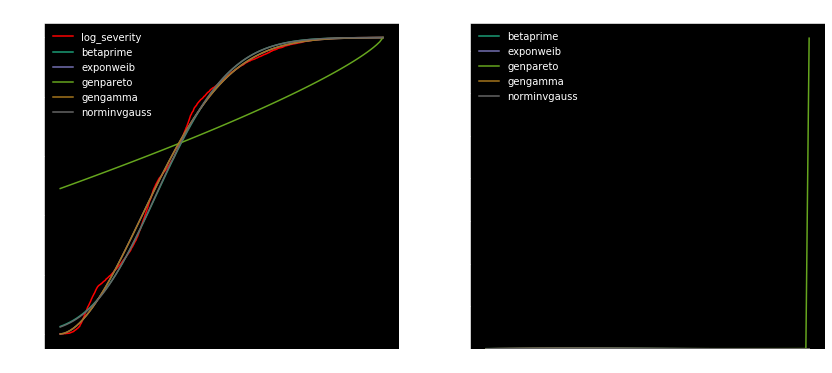

In [28]:
fitted, ks_df, param_df = fit_distns(log_severity, 'log_severity', all_dists)

Remove some false positives

In [ ]:
exclude = ['genpareto', 'levy_l', 'truncnorm', 'reciprocal', 'lomax']
for e in exclude:
    del fitted[e]

When plotted, genpaerto and levy_l show cdfs and pdfs which clearly do not follow the distribution of the data and truncnorm, and reciprocal yielded nan values for AIC. lomax had p-value of zero (meaning floating point precision was not small enough)

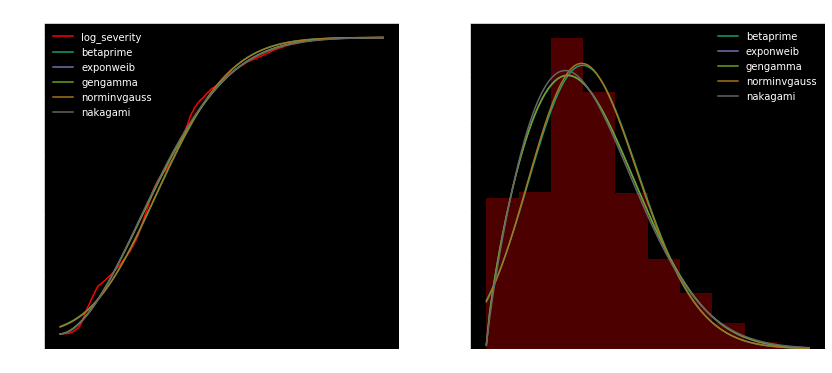

In [61]:
plot_distns(log_severity, fitted, 'log_severity').show()

In [62]:
ks_df.loc[fitted.keys(), :].sort_values('p-value')

,ks_statistic,p-value
nakagami,0.046216,2.267947e-17
norminvgauss,0.044910,1.992652e-16
exponweib,0.044495,3.923315e-16
gengamma,0.044482,4.010476e-16
betaprime,0.043167,3.294211e-15


In [63]:
param_df.loc[fitted.keys(), :].sort_values(['aic'])

,llf,aic,bic
gengamma,-8529.262290,17066.524579,17095.003615
exponweib,-8529.403761,17066.807523,17095.286559
nakagami,-8533.701022,17073.402045,17094.761322
norminvgauss,-8881.623874,17771.247747,17799.726783
betaprime,-8905.221271,17818.442542,17846.921578


Looks like our initial fit wasn't too far from the mark, with exponweib appearing near the top distributions. Yet, for all distributions, we reject the null hypotheses and conclude that the data does not come from any of these distributions.

# Putting it in practice

Despite the results above, let's take the top distributions and put them into practice by creating an estimate for the total claim severity in some time period.

I don't know what are the period the claims took places and we don't have a distribution of claim count for that period. Let's assume that for the next period, we got the same number of claims.

We can use this to sample from the fitted distributions and calculate the total severity incurred for the next period.

In [100]:
claim_count = len(auto_claims)
claim_count

9134

In [97]:
def plot_severity_estimates(df):
    fig, ax = plt.subplots(figsize=(12,7))
    
    bp = ax.boxplot(df.to_numpy(), labels=df.columns)
    for e in ['caps', 'boxes', 'fliers', 'means', 'whiskers', 'medians']:
        plt.setp(bp[e], color='cyan')
        
    plt.setp(bp['fliers'], markeredgecolor='cyan')
    plt.show()
    
def mc_sampling(fitted, claim_count=claim_count, n=1000):
    temp = {}
    for name, frozen_dist in fitted.items():
        temp[name] = [np.exp(frozen_dist.rvs(size=claim_count)).sum() 
                      for i in range(n)]
    df = pd.DataFrame(temp).reset_index(drop=True)
    plot_severity_estimates(df)
    return df

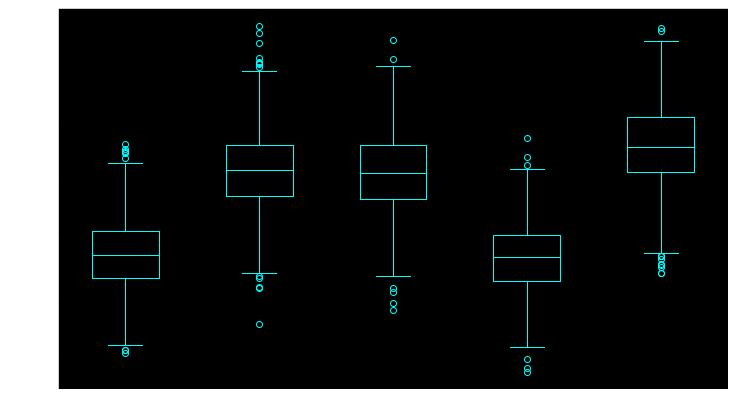

In [98]:
df = mc_sampling(fitted) 

In [102]:
df.describe()

,betaprime,exponweib,gengamma,norminvgauss,nakagami
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,7.174554e+06,7.320158e+06,7.318392e+06,7.166332e+06,7.362411e+06
std,5.967699e+04,7.063242e+04,6.875937e+04,5.919806e+04,7.226887e+04
min,7.001572e+06,7.051259e+06,7.075572e+06,6.968517e+06,7.139907e+06
25%,7.132759e+06,7.275252e+06,7.270870e+06,7.125933e+06,7.317009e+06
50%,7.171345e+06,7.320803e+06,7.315311e+06,7.167915e+06,7.360398e+06
75%,7.213742e+06,7.364528e+06,7.364315e+06,7.206347e+06,7.414191e+06
max,7.366983e+06,7.573355e+06,7.547464e+06,7.376139e+06,7.568595e+06


The boxplots show statistics for the severity incurred by taking approx 9100 samples from each distribution 1000 times.

In [104]:
auto_claims['Claim Amount'].sum()

7311712.6298532

Next steps:

* Once the above is done, can we compare it to a ML model that forecasts total cost of claims?